# IA353 - Redes Neurais
# EFC3 - Questão 6 - Parte 3

## Predição de séries temporais empregando vários tipos de modelos

## Caso de estudo: Série temporal de temperatura máxima por hora na cidade do Rio de Janeiro, no período de 01/01/2021 à 31/03/2021. Dados obtidos no site do Instituto Nacional de Meteorologia (INMET): https://bdmep.inmet.gov.br.

**Professor:** Fernando J. Von Zuben <br>
**Aluno(a):** Matheus dos Santos Rodrigues 

### 6.1. Importações e definições

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
from pathlib import Path
import pandas as pd
import math
import csv
import sklearn
import sklearn.preprocessing
import datetime
from pandas import DataFrame
from pandas import concat

# Specifi imports
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time Steps")
    plt.ylabel("Time Series Values")
    plt.title("Sunspots Time Series")
    plt.grid(True)

### 6.2. Carregando a base de dados e apresentando sua composição

In [ ]:
# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10 
test_set_size_percentage = 10 

from google.colab import files
uploaded = files.upload()
import io

series = np.loadtxt("Dados_Temp_RJ.txt", dtype='f', delimiter='\n')
series = series/15
series = series - np.mean(series)
print(series)

Saving Dados_Temp_RJ.txt to Dados_Temp_RJ (3).txt
[-0.09717274 -0.1371727  -0.09717274 ... -0.03050601 -0.06383944
 -0.06383944]


### 6.3. Exibindo o comportamento temporal da série

Text(0, 0.5, 'Valor da série')

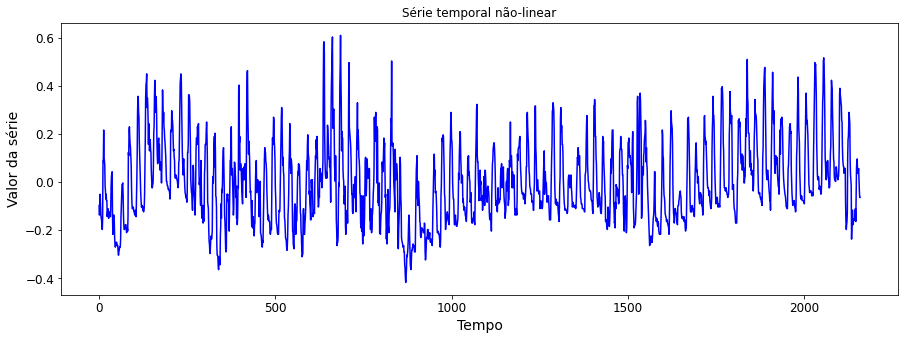

In [ ]:
plt.figure(figsize=(15, 5));
plt.plot(series, color='blue', label='open')
plt.title('Série temporal')
plt.xlabel('Tempo')
plt.ylabel('Valor da série')

### 6.4. Preparação da série temporal com linha de derivação de atraso, além de promover o particionamento entre conjuntos de treinamento, validação e teste

In [ ]:
# function to create train, validation, test data given stock data and sequence length
def load_data(series, seq_len):
    data_raw = np.array(series) # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len - 1): 
        data.append(data_raw[index: index + seq_len + 1])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
        
    x_train = data[:train_set_size,:-1]
    y_train = data[:train_set_size,-1]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1]
    
    x_test = data[train_set_size+valid_set_size:,:-1]
    y_test = data[train_set_size+valid_set_size:,-1]
    
    x_train = np.asarray(x_train)
    y_train = np.asarray(y_train)
    y_train = y_train.reshape(-1,1)
    x_valid = np.asarray(x_valid)
    y_valid = np.asarray(y_valid)
    y_valid = y_valid.reshape(-1,1)
    x_test = np.asarray(x_test)
    y_test = np.asarray(y_test)
    y_test = y_test.reshape(-1,1)
    
    np.savetxt('Q6P2_x_train.txt', x_train)
    np.savetxt('Q6P2_y_train.txt', y_train)
    np.savetxt('Q6P2_x_valid.txt', x_valid)
    np.savetxt('Q6P2_y_valid.txt', y_valid)
    np.savetxt('Q6P2_x_test.txt', x_test)
    np.savetxt('Q6P2_y_test.txt', y_test)

    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

# create train, test data
seq_len = 24 # Número de atrasos a serem considerados
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(series, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (1707, 24)
y_train.shape =  (1707, 1)
x_valid.shape =  (214, 24)
y_valid.shape =  (214, 1)
x_test.shape =  (214, 24)
y_test.shape =  (214, 1)


### 6.5. Visualização do comportamento da série temporal de teste

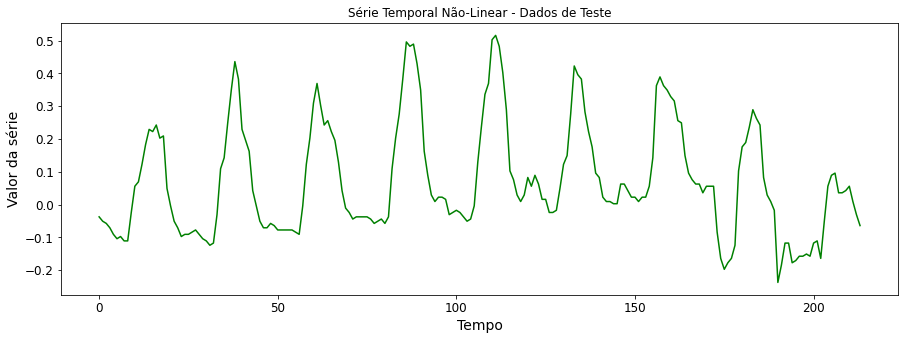

In [ ]:
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='green')
plt.title('Série Temporal Não-Linear - Dados de Teste')
plt.xlabel('Tempo')
plt.ylabel('Valor da série')
plt.show()

### 6.6. Sintetizando um preditor linear

In [ ]:
from sklearn.linear_model import LinearRegression

nr,nc = x_train.shape
B = np.ones((nr,1))
X = np.hstack((x_train,B))
lr = LinearRegression()
lr.fit(X, y_train)
w = lr.coef_[0]
print('Coeficientes do preditor linear')
print(w)

Coeficientes do preditor linear
[-6.74827504e-02  7.15149750e-02  1.15640151e-01  2.57582188e-02
  3.09655544e-03  9.98586612e-03 -3.19141459e-04  4.11093454e-02
 -1.91960029e-02 -6.84677319e-02  1.87561860e-02  3.58356863e-02
 -6.50468567e-02  4.21807663e-02  2.29899633e-02  1.57694494e-02
 -6.45289223e-02  2.99267605e-02 -6.26780297e-02  1.08125470e-01
 -1.28334642e-01  2.89898580e-02 -1.43202338e-01  9.95365775e-01
  0.00000000e+00]


#### 6.6.1. Visualização do desempenho do preditor linear

In [ ]:
from sklearn.metrics import mean_squared_error

print('EQM final de treinamento após o término do treinamento - Preditor Linear')
nr,nc = x_train.shape
B = np.ones((nr,1))
X = np.hstack((x_train,B))
y_pred = X.dot(w)
MSE_train = mean_squared_error(y_train,y_pred)
print(MSE_train)
print('EQM final de validação após o término do treinamento - Preditor Linear')
nr,nc = x_valid.shape
B = np.ones((nr,1))
X = np.hstack((x_valid,B))
y_pred = X.dot(w)
MSE_valid = mean_squared_error(y_valid,y_pred)
print(MSE_valid)
print('EQM final de teste após o término do treinamento - Preditor Linear')
nr,nc = x_test.shape
B = np.ones((nr,1))
X = np.hstack((x_test,B))
y_pred = X.dot(w)
MSE_test = mean_squared_error(y_test,y_pred)
print(MSE_test)

EQM final de treinamento após o término do treinamento - Preditor Linear
0.003618472056296871
EQM final de validação após o término do treinamento - Preditor Linear
0.0025166054659955636
EQM final de teste após o término do treinamento - Preditor Linear
0.0020893514830869955


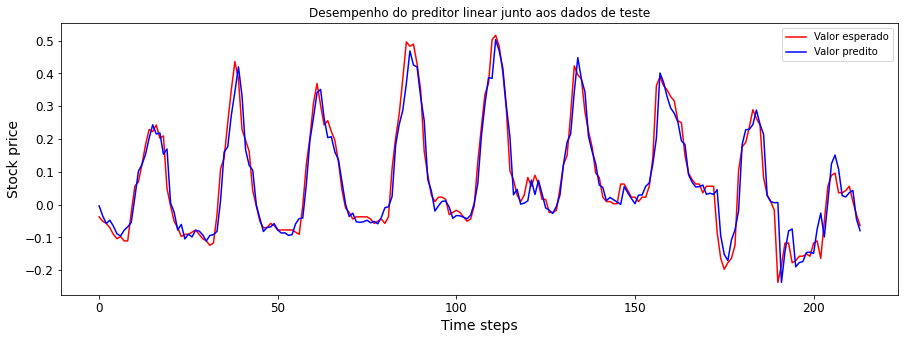

In [ ]:
y_pred = X.dot(w)
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='red', label='Valor esperado')
plt.plot(y_pred, color='blue', label='Valor predito')
plt.title('Desempenho do preditor linear junto aos dados de teste')
plt.xlabel('Time steps')
plt.ylabel('Stock price')
plt.legend(loc='best')
plt.show()

### 6.7. Sintetizando um preditor não-linear MLP

In [ ]:
EPOCHS = 100
np.random.seed(42)
tf.random.set_seed(42)

model_MLP = keras.models.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation=tf.nn.tanh),
    keras.layers.Dense(64, activation=tf.nn.tanh),
    keras.layers.Dense(1)
])

model_MLP.compile(loss="mse", optimizer="adam")

earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=EPOCHS) # Se desejar early stopping, definir patience = 10
best_val = ModelCheckpoint('model_MLP_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)
history = model_MLP.fit(x_train, y_train, 
                        epochs=EPOCHS, 
                        validation_data=(x_valid, y_valid), 
                        callbacks=[earlystop, best_val], 
                        verbose=1)

Epoch 1/100
54/54 [==============================] - 1s 4ms/step - loss: 0.0215 - val_loss: 0.0027
Epoch 2/100
54/54 [==============================] - 0s 3ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 3/100
54/54 [==============================] - 0s 2ms/step - loss: 0.0043 - val_loss: 0.0057
Epoch 4/100
54/54 [==============================] - 0s 2ms/step - loss: 0.0044 - val_loss: 0.0024
Epoch 5/100
54/54 [==============================] - 0s 2ms/step - loss: 0.0040 - val_loss: 0.0029
Epoch 6/100
54/54 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 0.0041
Epoch 7/100
54/54 [==============================] - 0s 2ms/step - loss: 0.0042 - val_loss: 0.0038
Epoch 8/100
54/54 [==============================] - 0s 2ms/step - loss: 0.0039 - val_loss: 0.0031
Epoch 9/100
54/54 [==============================] - 0s 2ms/step - loss: 0.0042 - val_loss: 0.0034
Epoch 10/100
54/54 [==============================] - 0s 2ms/step - loss: 0.0038 - val_loss: 0.0027
Epoch 11/

In [ ]:
model_MLP.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 24)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               3200      
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 11,521
Trainable params: 11,521
Non-trainable params: 0
_________________________________________________________________


#### 6.7.1. Carregando o modelo com o menor MAPE para o preditor MLP

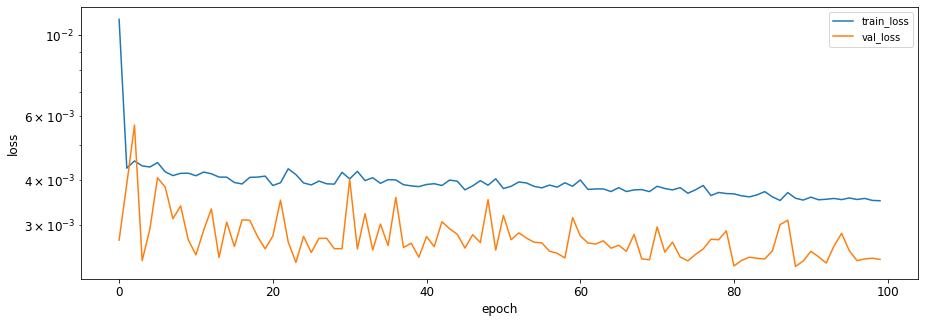

In [ ]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model_MLP.load_weights("model_MLP_{:02d}.h5".format(best_epoch))
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

#### 6.7.2. Visualização do desempenho do preditor MLP

In [ ]:
#weights = model_MLP.get_weights()
#print(weights)
print('EQM final de treinamento após o término do treinamento - Preditor MLP')
y_pred = model_MLP.predict(x_train)
MSE_train = mean_squared_error(y_train,y_pred)
print(MSE_train)
print('EQM final de validação após o término do treinamento - Preditor MLP')
y_pred = model_MLP.predict(x_valid)
MSE_valid = mean_squared_error(y_valid,y_pred)
print(MSE_valid)
print('EQM final de teste após o término do treinamento - Preditor MLP')
y_pred = model_MLP.predict(x_test)
MSE_test = mean_squared_error(y_test,y_pred)
print(MSE_test)

EQM final de treinamento após o término do treinamento - Preditor MLP
0.0033940931
EQM final de validação após o término do treinamento - Preditor MLP
0.0023131832
EQM final de teste após o término do treinamento - Preditor MLP
0.0020470216


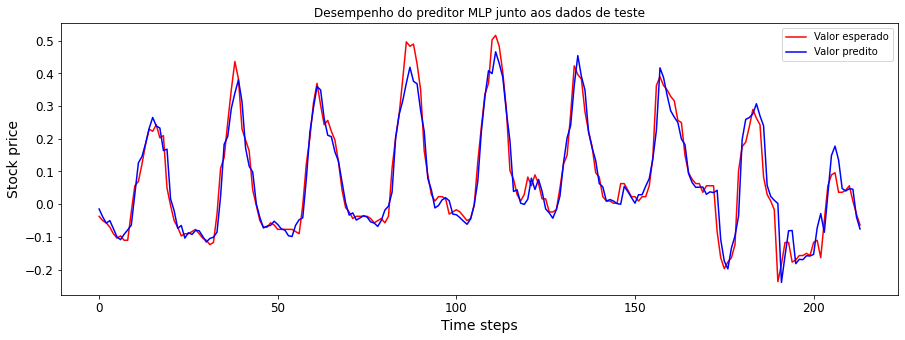

In [ ]:
y_pred = model_MLP.predict(x_test)
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='red', label='Valor esperado')
plt.plot(y_pred, color='blue', label='Valor predito')
plt.title('Desempenho do preditor MLP junto aos dados de teste')
plt.xlabel('Time steps')
plt.ylabel('Stock price')
plt.legend(loc='best')
plt.show()

-------------------------------------------------
### COMENTÁRIOS



*   É sabido da literatura que modelos estocásticos lineares possuem boa performance para previsão de séries temporais de temperatura, pois esses dados possuem uma distribuição apriximadamente Gaussiana com uma função de autocorrelação de decaimento exponencial (Brandley e Kants, 2015). Assim, o regressor linear parecia ser um bom candidato, a priore.
*  A escolha do classificador não linear como a MLP, se deu porque foi o modelo que gerou os melhores resultados. Além disso, foi escolhido o arbitrariamente o número de atrasos como "24" por compreender 1 dia inteiro, e dessa forma deve fornecer informação suficiente para a predição, visto que deseja-se apenas 1 passo a frente. Outrossim, também foram testados outros intervalos menores, que geraram resultados similares.
* Como pode ser observado diretamente dos plots,os preditores apresentaram bom desempenho, mas erraram mais próximos aos picos, ou nas regiões onde ocorreram mudanças bruscas de temperatura. Esses comportametos já eram esperados, das discussões da parte 1 e 2, visto a natureza da série temporal (dados climáticos de temperatura) que encapsula muitas outras variáveis.




## Referências
  * BRADLEY, E. & KANTZ, H. (2015). Nonlinear time-series analysis revisited.arXiv:1503.07493v1.